In [64]:
import os
import numpy as np
from spectral import *
import matplotlib.pyplot as plt
import math
import cv2
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn import preprocessing

DATASTORE = 'C:\\Datasets\\bacterias'
spectral.settings.envi_support_nonlowercase_params = True


In [76]:
from sklearn.cluster import KMeans
from math import factorial

def calibration(arr, I, W, D):
    for w in range(arr.shape[2]):
        if (w % 10 == 0):
            print('CAMADAS {}-{}'.format(w, w+10))

        WW = np.mean(W[:, :, w], axis=0).T
        DD = np.mean(D[:, :, w], axis=0).T
        
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                den = WW[0, j] - DD[0, j]
                num = I[i, j, w] - DD[0, j]
                if den and num/den > 0:
                    arr[i, j, w] = -math.log10(num / den)
                else:
                    arr[i, j, w] = 0
    return arr

def hsi2matrix(arr):
    if len(arr.shape) != 3:
        raise BaseException('A entrada deve possuir 3 dimensões')

    r, c, w = arr.shape
    return np.reshape(arr, (r*c, w))

def mat2hsi(mat, shape):
    return np.reshape(mat, shape)

def pca_95(x):
    scaled_data = preprocessing.scale(x)
    return PCA(n_components=0.95).fit_transform(scaled_data)

def get_clusters(x):
    pca_data = pca_95(x)
    km = KMeans(n_clusters=2).fit(pca_data)
    return km

def get_layer(hsi, layer):
    return hsi[:,:,layer]


def savitzky_golay_filter(y, window_size, order, deriv=0, rate=1):
    order_range = range(order+1)
    half_window = (window_size - 1) // 2
    b = np.mat([[k**i for i in order_range]
               for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    firstvals = y[0] - np.abs(y[1:half_window+1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

def snv_filter(mat):
    nmat = np.copy(mat)
    mean = np.mean(mat, axis=1)
    std = np.std(mat, axis=1)
    for i in range(mat.shape[0]):
        nmat[i] = (nmat[i] - mean[i])/std[i]

    return nmat

def remove_pixels(mat, side, amount):
    cpy_mat = np.copy(mat)
    if side == 'top':
        for i in range(amount):
            cpy_mat[i, :, :] = 0
    return cpy_mat

def apply_mask(km,mat):
    mask1 = np.copy(mat)
    mask2 = np.copy(mat)
    lab = km.labels_
    for i in range(mat.shape[0]):
        if lab[i] == 0:
            mask1[i] = 0
        else:
            mask2[i] = 0
    
    return (mat2hsi(mask1, mat.shape) ,mat2hsi(mask2, mat.shape))


def hsi_remove_background(mat):
    mat_cpy = np.copy(mat)
    for i in range(mat.shape[0]):
        mat_cpy[i] = savitzky_golay_filter(mat_cpy[i], 21, 2, 1)

    matSNVFilter = snv_filter(mat_cpy)
    km = get_clusters(matSNVFilter)
    m1, m2 = apply_mask(km, mat)
    return (m1,m2,km)
    
def which_cluster_to_mantain(mask1, mask2):
    plt.figure()
    plt.title("FIGURE 1")
    plt.imshow(get_layer(mask1, 1), cmap='gray')
    plt.figure()
    plt.title("FIGURE 2")
    plt.imshow(get_layer(mask2, 2), cmap='gray')
    plt.show()
    
    resp = int(input('Qual cluster deseja manter? (1/2)'))
    if resp != 1 and resp != 2:
        raise BaseException("Selected option not available.")
    
    return resp - 1
    
def get_hsi_data(path):
    orig_name = [a for a in os.listdir(path) if '.hdr' in a and 'DARK' not in a and 'WHITE' not in a]
    dark_name = [a for a in os.listdir(path) if '.hdr' in a and 'DARK' in a]
    white_name = [a for a in os.listdir(path) if '.hdr' in a and 'WHITE' in a]

    I = open_image(os.path.join(path, orig_name[0]))
    W = open_image(os.path.join(path, white_name[0]))
    D = open_image(os.path.join(path, dark_name[0]))

    arr = I.load()

    return (arr, I, W, D)

def get_no_background_pixels(cluster: int, km, mat):
    lab = km.labels_
    print(lab, mat.shape[0])
    arr = []
    for i in range(mat.shape[0]):
        if lab[i] == cluster:
            arr.append(mat[i,:])
    return arr

def create_training_data_full(choose_bac: int):
    """
        choose_bac is the bacteria to process (since takes forever to do all at once)
        returns a calibrated array based on dark and white hdr's, the pixels containing the bacteria (with no background) and the label for that bacteria
    """

    bac_dirs = os.listdir(DATASTORE)

    for ind, bac in enumerate(bac_dirs):
        if (choose_bac == ind):

            individual_bac_dir = os.path.join(DATASTORE, bac)

            arr, I, W, D = get_hsi_data(individual_bac_dir)

            arr_calib = calibration(arr, I, W, D)

            mat = hsi2matrix(arr)
            mask1, mask2, km = hsi_remove_background(mat)
            mask1 = mat2hsi(mask1, arr.shape)
            mask2 = mat2hsi(mask2, arr.shape)

            selected_cluster = which_cluster_to_mantain(mask1, mask2)
            noBackPixels = get_no_background_pixels(selected_cluster, km, mat)
            return [arr_calib, noBackPixels, ind]
            


def create_training_data_from_calibration(arr_calib):
    mat = hsi2matrix(arr_calib)
    mask1, mask2, km = hsi_remove_background(mat)
    mask1 = mat2hsi(mask1, arr_calib.shape)
    mask2 = mat2hsi(mask2, arr_calib.shape)

    cluster = which_cluster_to_mantain(mask1, mask2)
    noBackPixels = get_no_background_pixels(cluster, km, mat)
    return noBackPixels


CAMADAS 0-10
CAMADAS 10-20
CAMADAS 20-30
CAMADAS 30-40
CAMADAS 40-50
CAMADAS 50-60
CAMADAS 60-70
CAMADAS 70-80
CAMADAS 80-90
CAMADAS 90-100
CAMADAS 100-110
CAMADAS 110-120
CAMADAS 120-130
CAMADAS 130-140
CAMADAS 140-150
CAMADAS 150-160
CAMADAS 160-170
CAMADAS 170-180
CAMADAS 180-190
CAMADAS 190-200
CAMADAS 200-210
CAMADAS 210-220
CAMADAS 220-230
CAMADAS 230-240
CAMADAS 240-250
CAMADAS 250-260


C:\Users\Vinicius Moraes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Vinicius Moraes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


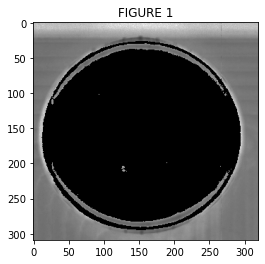

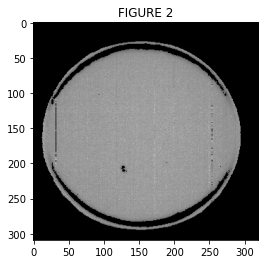

[1 1 1 ... 1 1 1] 98880


In [77]:
calib_arr, nobackpix, ind = create_training_data_full(0)

In [ ]:
# f = loadmat(os.path.join(DATASTORE, 'a.mat'))
# aaaa = np.array(f['data'])
# print(aaaa.shape, mask1hsi.shape)
# plt.imshow(aaaa[:,:,0], cmap='gray')

# path = os.path.join(DATASTORE, 'teste')

# orig_name = 'a.hdr'
# dark_name = 'd.hdr'
# white_name = 'w.hdr'

# I = open_image(os.path.join(path, orig_name))
# W = open_image(os.path.join(path, white_name))
# D = open_image(os.path.join(path, dark_name))

# arr = I.load()

# mat = hsi2matrix(arr)
# m1, m2, km = hsi_remove_background(mat)
# mm1 = mat2hsi(m1, arr.shape)
# mm2 = mat2hsi(m2, arr.shape)

# sc = which_cluster_to_mantain(mm1, mm2)
# noBackPixels = get_no_background_pixels(0, km, mat)
